In [1]:
# HIDE CODE
from dateutil.relativedelta import relativedelta
from joblib import dump, load
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import cm
matplotlib.rcParams.update({'font.size': 12})


import warnings
import sys
import os
sys.path.append('/home/server/gli-data-science/')
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore" # Also affect subprocesses

import os
import ds_db
import helper_db
from helper import transform_to_rupiah, rupiah_format

import pickle
import pandas as pd
import numpy as np

from datetime import datetime, timedelta

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.float_format', lambda x: '%.1f' % x)
pd.options.mode.chained_assignment = None  # default='warn'
from IPython.display import display, HTML, display_html, IFrame
import ipywidgets as ipyw

def side_by_side_display(dfs:list, captions:list):
    output = ""
    combined = dict(zip(captions, dfs))
    styles = [
        dict(selector="caption", props=[("caption-side", "center"), ("font-size", "100%"), ("color", )])]
    for caption, df in combined.items():
        output += df.style.set_table_attributes("style='display:inline; font-size:85%' ").set_precision(2).set_caption(caption)._repr_html_()
        output += "\xa0\xa0\xa0\xa0"

    display(HTML(output))

    
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression, PoissonRegressor, Ridge, Lasso, RANSACRegressor, RidgeClassifier, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, BaggingClassifier, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeRegressor, export_text, DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVR, SVC, LinearSVC
import xgboost as xgb 


from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.model_selection import train_test_split


import textwrap
def split_label(list_label):
    list_label = list(list_label)
    list_label = ["<br>".join(textwrap.wrap(t, width=12)) for t in list_label ]
    return list_label

### ide kasar
> 
* daily job to loop all member alfagift 10 juta
* compute feature trx voucher used, # of trx, # of sales
* compute feature event app site open / view product / atc
* updating each feature and re predict churn feature
* lets play in month - 3 for each define trx and event feature

In [73]:
df_pv_ = pd.read_csv('./pv_31Dec21.csv')
df_pv_['EVENT_TIME'] = pd.to_datetime(df_pv_['EVENT_TIME']).dt.strftime('%Y-%m')

df_pv = df_pv_.groupby(['TRO_MEMBERS','EVENT_TIME']).agg(PV=('COUNT_VIEW_PRODUCT','sum'))\
        .unstack(level=1).fillna(0).reset_index()

df_pv.columns = [' '.join(col).strip().upper() for col in df_pv.columns.values]
df_pv = df_pv.drop(['PV 2021-08'], 1)

In [76]:
df_re_g_u = pd.read_csv('./rating_2022-01-01.csv')
df_re_g_u = df_re_g_u.drop(['RATING_BELOW 2021-08', 'RATING_AVG 2021-08'],1)

In [7]:
# HIDE CODE

## USING ORDER
import glob

df_tto = []
for end_date in pd.date_range('2021-08-01', '2022-01-01', freq='M'):
    start_date = end_date.replace(day=1)
    end_date_save = start_date + relativedelta(months=1)
    
    start_date_str = start_date.strftime('%d%b%y')
    end_date_str = end_date_save.strftime('%d%b%y')
    
    print(start_date_str, end_date_str)
    
    pf = '/home/server/gli-data-science/data/trans_oshop/{}_{}.csv'.format(start_date_str, end_date_str)
    df_tto.append(pd.read_csv(pf, sep='\t', dtype='object'))
    
df_tto = pd.concat(df_tto)

df_tto = df_tto[df_tto['TRO_MEMBERS'] != 'N']
df_tto['TRO_DATE'] = pd.to_datetime(df_tto['TRO_DATE'])
df_tto['TRO_NET'] = df_tto['TRO_NET'].astype('float', errors='ignore').astype('int', errors='ignore')


df_tto['TRO_QTY'] = df_tto['TRO_QTY'].astype(int)

01Aug21 01Sep21
01Sep21 01Oct21
01Oct21 01Nov21
01Nov21 01Dec21
01Dec21 01Jan22


In [65]:
df_tto.head()

,TRO_DATE,TRO_CART_ID,TRO_KD_STORE,TRO_BRANCH_CODE,BRANCH_CODE,TRO_MEMBERS,TRO_NO_ORDER,TRO_PLU,TRO_QTY,TRO_VOUCHER_USAGE,TRO_PAYMENT_METHOD,TRO_NET,TRO_SHIP_METHOD,TRO_STATUS_SAPA,TRO_STATUS_RETUR,TRO_DATE_MONTH
0,2021-08-04,9310011,M705,YZ01,YZ01,9990012547663800,O-210804-AGPFMFQ,117289,1,0.0,sat-cod,31818,1,Y,N,2021-08
4,2021-08-04,9311223,M705,YZ01,YZ01,9990012491276437,O-210804-AGFMMMR,103001,2,0.0,sat-cod,363,1,Y,N,2021-08
5,2021-08-04,9311223,M705,YZ01,YZ01,9990012491276437,O-210804-AGFMMMR,414212,6,0.0,sat-cod,77454,1,Y,N,2021-08
6,2021-08-04,9311223,M705,YZ01,YZ01,9990012491276437,O-210804-AGFMMMR,421482,1,0.0,sat-cod,6818,1,Y,N,2021-08
7,2021-08-04,9314127,M705,YZ01,YZ01,9990013368444667,O-210804-AGJPFDV,103001,2,0.0,shopeepay,363,0,Y,N,2021-08


In [82]:
df_tto['TRO_VOUCHER_USAGE'] = df_tto['TRO_VOUCHER_USAGE'].astype('float', errors='ignore').astype('int', errors='ignore')
df_tto['TRO_DATE_MONTH'] = df_tto['TRO_DATE'].dt.strftime('%Y-%m')

df_tto_sel = df_tto[(df_tto['TRO_DATE'] >= '2021-09-01') \
            & (df_tto['TRO_DATE'] <= '2021-12-31')]

In [83]:
df_sla = pd.read_csv('./sla_31Dec21.csv')
df_sla['ATT_SEND_DATE_TOSTORE'] = pd.to_datetime(df_sla['ATT_SEND_DATE_TOSTORE'])
df_sla['SLA'] = np.where(df_sla['SLA_NORM']< 0, 20, df_sla['SLA_NORM'])

df_tto_sel = pd.merge(df_tto_sel, df_sla, left_on='TRO_NO_ORDER', right_on='ATT_ORDER_ID', how='left')
df_tto_sel = df_tto_sel.drop(['ATT_ORDER_ID','ATT_ORDER_DATE','ATT_DELIVERY_DATE','ATT_SEND_DATE_TOSTORE','SLA_NORM'],1)

## create feature
df_tto_sel['SLA'] = df_tto_sel['SLA'].fillna(20)
df_tto_sel['SLA_LATE'] = np.where(df_tto_sel['SLA'] > 60, 1,0)

In [84]:
df_tto_sel[df_tto_sel['TRO_MEMBERS'] == '9990013498960629'].head()

,TRO_DATE,TRO_CART_ID,TRO_KD_STORE,TRO_BRANCH_CODE,BRANCH_CODE,TRO_MEMBERS,TRO_NO_ORDER,TRO_PLU,TRO_QTY,TRO_VOUCHER_USAGE,TRO_PAYMENT_METHOD,TRO_NET,TRO_SHIP_METHOD,TRO_STATUS_SAPA,TRO_STATUS_RETUR,TRO_DATE_MONTH,SLA,SLA_LATE
13712390,2021-12-30,17517399,J450,JZ01,JZ01,9990013498960629,O-211230-AGHJYWJ,221587,4,0.0,GO-PAY,50000,0,N,N,2021-12,1930.3,1
13749359,2021-12-30,17517399,J450,JZ01,JZ01,9990013498960629,O-211230-AGHJYWJ,7760,5,0.0,GO-PAY,60000,0,N,N,2021-12,1930.3,1
14979057,2021-12-25,17067880,J450,JZ01,JZ01,9990013498960629,O-211225-AGWDJTN,7760,4,0.0,GO-PAY,48000,0,N,N,2021-12,1683.3,1
14979058,2021-12-25,17067880,J450,JZ01,JZ01,9990013498960629,O-211225-AGWDJTN,129021,1,0.0,GO-PAY,11818,0,N,N,2021-12,1683.3,1
14979059,2021-12-25,17067880,J450,JZ01,JZ01,9990013498960629,O-211225-AGWDJTN,406643,4,0.0,GO-PAY,50000,0,N,N,2021-12,1683.3,1


In [15]:
df_mem_push = df_tto_sel[['TRO_MEMBERS']].drop_duplicates()
from sqlalchemy import event,create_engine,types



driver = 'cx_oracle'
server = '10.234.152.61' 
database = 'alfabi' 
username = 'report' 
password = 'justd0it'
engine_stmt = "oracle://%s:%s@%s/%s" % (username, password, server, database )

engine = create_engine(engine_stmt)

df = df_mem_push.astype(str)
dtyp = {c:types.VARCHAR(df[c].str.len().max()) for c in df.columns[df.dtypes == 'object'].tolist()}
df.to_sql('temp_churn', engine, index=False, if_exists="replace", dtype=dtyp)

engine.dispose()





In [21]:
q = '''
SELECT 
	tc.TRO_MEMBERS, 
	(TO_DATE('2021/12/07', 'yyyy/mm/dd')) - zt.tgl_registrasi AS SINCE_REGIS
FROM 
	TEMP_CHURN tc
LEFT JOIN (
	select 
		char1 no_member, char4 jenis_kelamin, char5 status_nikah, date1 tgl_lahir, date2 tgl_registrasi
	from 
		report.ztampungan
	where 
		pk='MEMBERALFAGIFT2'
) zt ON zt.no_member = tc.TRO_MEMBERS 

'''

con = ds_db.connect_alfabi()

df_regis = pd.read_sql_query(q, con)

con.close()

You are connected


In [24]:
df_regis['SINCE_REGIS'] = df_regis['SINCE_REGIS'].fillna('-1')

In [85]:
df_tto_sel_g = df_tto_sel.groupby(['TRO_MEMBERS','TRO_DATE_MONTH','TRO_NO_ORDER'])\
                        .agg({'TRO_NET':'sum',
                              'TRO_NO_ORDER':'nunique',
                              'SLA':'first',
                              'SLA_LATE':'first',
                              'TRO_VOUCHER_USAGE':'sum',
                              'TRO_PAYMENT_METHOD':'first'
                              ''
                             })
df_tto_sel_g = df_tto_sel_g.groupby(['TRO_MEMBERS','TRO_DATE_MONTH'])\
                        .agg({'TRO_NET':'sum',
                              'TRO_NO_ORDER':'sum',
                              'SLA':'sum',
                              'SLA_LATE':'sum',
                              'TRO_VOUCHER_USAGE':'sum',
                              'TRO_PAYMENT_METHOD':'nunique'
                             })

## untack net and count order

In [86]:
df_tto_sel_g_u = df_tto_sel_g.unstack(level=1).fillna(0).reset_index()
df_tto_sel_g_u.columns = [' '.join(col).strip().upper() for col in df_tto_sel_g_u.columns.values]

In [87]:
df_re_g_u['TRO_MEMBERS'] = df_re_g_u['TRO_MEMBERS'].astype(str)

## merge with rating

In [88]:
df_tto_re = pd.merge(df_tto_sel_g_u, df_re_g_u, on='TRO_MEMBERS', how='left').fillna(0)

In [89]:
df_tto_re.head()

,TRO_MEMBERS,TRO_NET 2021-09,TRO_NET 2021-10,TRO_NET 2021-11,TRO_NET 2021-12,TRO_NO_ORDER 2021-09,TRO_NO_ORDER 2021-10,TRO_NO_ORDER 2021-11,TRO_NO_ORDER 2021-12,SLA 2021-09,SLA 2021-10,SLA 2021-11,SLA 2021-12,SLA_LATE 2021-09,SLA_LATE 2021-10,SLA_LATE 2021-11,SLA_LATE 2021-12,TRO_VOUCHER_USAGE 2021-09,TRO_VOUCHER_USAGE 2021-10,TRO_VOUCHER_USAGE 2021-11,TRO_VOUCHER_USAGE 2021-12,TRO_PAYMENT_METHOD 2021-09,TRO_PAYMENT_METHOD 2021-10,TRO_PAYMENT_METHOD 2021-11,TRO_PAYMENT_METHOD 2021-12,RATING_BELOW 2021-09,RATING_BELOW 2021-10,RATING_BELOW 2021-11,RATING_BELOW 2021-12,RATING_AVG 2021-09,RATING_AVG 2021-10,RATING_AVG 2021-11,RATING_AVG 2021-12
0,006506519712,0.0,0.0,50362.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,9990010000001200,1791590.0,2412654.0,3117811.0,3217556.0,20.0,35.0,49.0,40.0,217.1,480.8,630.1,710.1,0.0,1.0,0.0,1.0,0.0,0.0,200000.0,85000.0,1.0,1.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,9990010000004582,0.0,191267.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,9951.7,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,9990010000008534,202358.0,644400.0,165315.0,776032.0,4.0,10.0,3.0,8.0,73.3,214.9,93.3,159.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,70000.0,1.0,1.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,9990010000031123,0.0,0.0,412904.0,48908.0,0.0,0.0,4.0,1.0,0.0,0.0,34.6,359.2,0.0,0.0,0.0,1.0,0.0,0.0,10000.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [90]:
df_pv['TRO_MEMBERS'] = df_pv['TRO_MEMBERS'].astype(str)
df_tto_re_pv = pd.merge(df_tto_re, df_pv, on='TRO_MEMBERS', how='left').fillna(0)

## merge with regis

In [91]:
df_tto_re_pv = pd.merge(df_tto_re_pv, df_regis, on='TRO_MEMBERS')

In [92]:
df_tto_re_pv.shape

(616715, 38)

In [93]:
df_tto_re_pv = df_tto_re_pv[df_tto_re_pv['SINCE_REGIS'].astype(int) > 0]

In [94]:
df_tto_re_pv.head()

,TRO_MEMBERS,TRO_NET 2021-09,TRO_NET 2021-10,TRO_NET 2021-11,TRO_NET 2021-12,TRO_NO_ORDER 2021-09,TRO_NO_ORDER 2021-10,TRO_NO_ORDER 2021-11,TRO_NO_ORDER 2021-12,SLA 2021-09,SLA 2021-10,SLA 2021-11,SLA 2021-12,SLA_LATE 2021-09,SLA_LATE 2021-10,SLA_LATE 2021-11,SLA_LATE 2021-12,TRO_VOUCHER_USAGE 2021-09,TRO_VOUCHER_USAGE 2021-10,TRO_VOUCHER_USAGE 2021-11,TRO_VOUCHER_USAGE 2021-12,TRO_PAYMENT_METHOD 2021-09,TRO_PAYMENT_METHOD 2021-10,TRO_PAYMENT_METHOD 2021-11,TRO_PAYMENT_METHOD 2021-12,RATING_BELOW 2021-09,RATING_BELOW 2021-10,RATING_BELOW 2021-11,RATING_BELOW 2021-12,RATING_AVG 2021-09,RATING_AVG 2021-10,RATING_AVG 2021-11,RATING_AVG 2021-12,PV 2021-09,PV 2021-10,PV 2021-11,PV 2021-12,SINCE_REGIS
1,9990010000001200,1791590.0,2412654.0,3117811.0,3217556.0,20.0,35.0,49.0,40.0,217.1,480.8,630.1,710.1,0.0,1.0,0.0,1.0,0.0,0.0,200000.0,85000.0,1.0,1.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.0,27.0,46.0,38.0,931.0
2,9990010000004582,0.0,191267.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,9951.7,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,743.0
3,9990010000008534,202358.0,644400.0,165315.0,776032.0,4.0,10.0,3.0,8.0,73.3,214.9,93.3,159.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,70000.0,1.0,1.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,926.0
4,9990010000031123,0.0,0.0,412904.0,48908.0,0.0,0.0,4.0,1.0,0.0,0.0,34.6,359.2,0.0,0.0,0.0,1.0,0.0,0.0,10000.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,760.0
5,9990010000034518,48952.0,39453.0,65634.0,130813.0,2.0,1.0,2.0,3.0,1868.2,437.0,11.3,103.2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.0,0.0,4.0,4.0,909.0


In [95]:
df_tto_re_pv['NET_11-10'] = df_tto_re_pv['TRO_NET 2021-11'] - df_tto_re_pv['TRO_NET 2021-10']
df_tto_re_pv['NET_10-09'] = df_tto_re_pv['TRO_NET 2021-10'] - df_tto_re_pv['TRO_NET 2021-09']
df_tto_re_pv['NET_11-09'] = df_tto_re_pv['TRO_NET 2021-11'] - df_tto_re_pv['TRO_NET 2021-09']
df_tto_re_pv['STRUK_11-10'] = df_tto_re_pv['TRO_NO_ORDER 2021-11'] - df_tto_re_pv['TRO_NO_ORDER 2021-10']
df_tto_re_pv['STRUK_10-09'] = df_tto_re_pv['TRO_NO_ORDER 2021-10'] - df_tto_re_pv['TRO_NO_ORDER 2021-09']
df_tto_re_pv['STRUK_11-09'] = df_tto_re_pv['TRO_NO_ORDER 2021-11'] - df_tto_re_pv['TRO_NO_ORDER 2021-09']

In [40]:
# print(df_ins[df_ins['label'] == 1]['NET_11-10'].median())
# print(df_ins[df_ins['label'] == 1]['NET_10-09'].median())
# print(df_ins[df_ins['label'] == 1]['NET_11-09'].median())
# print(df_ins[df_ins['label'] == 1]['STRUK_11-10'].mean())
# print(df_ins[df_ins['label'] == 1]['STRUK_10-09'].mean())
# print(df_ins[df_ins['label'] == 1]['STRUK_11-09'].mean())

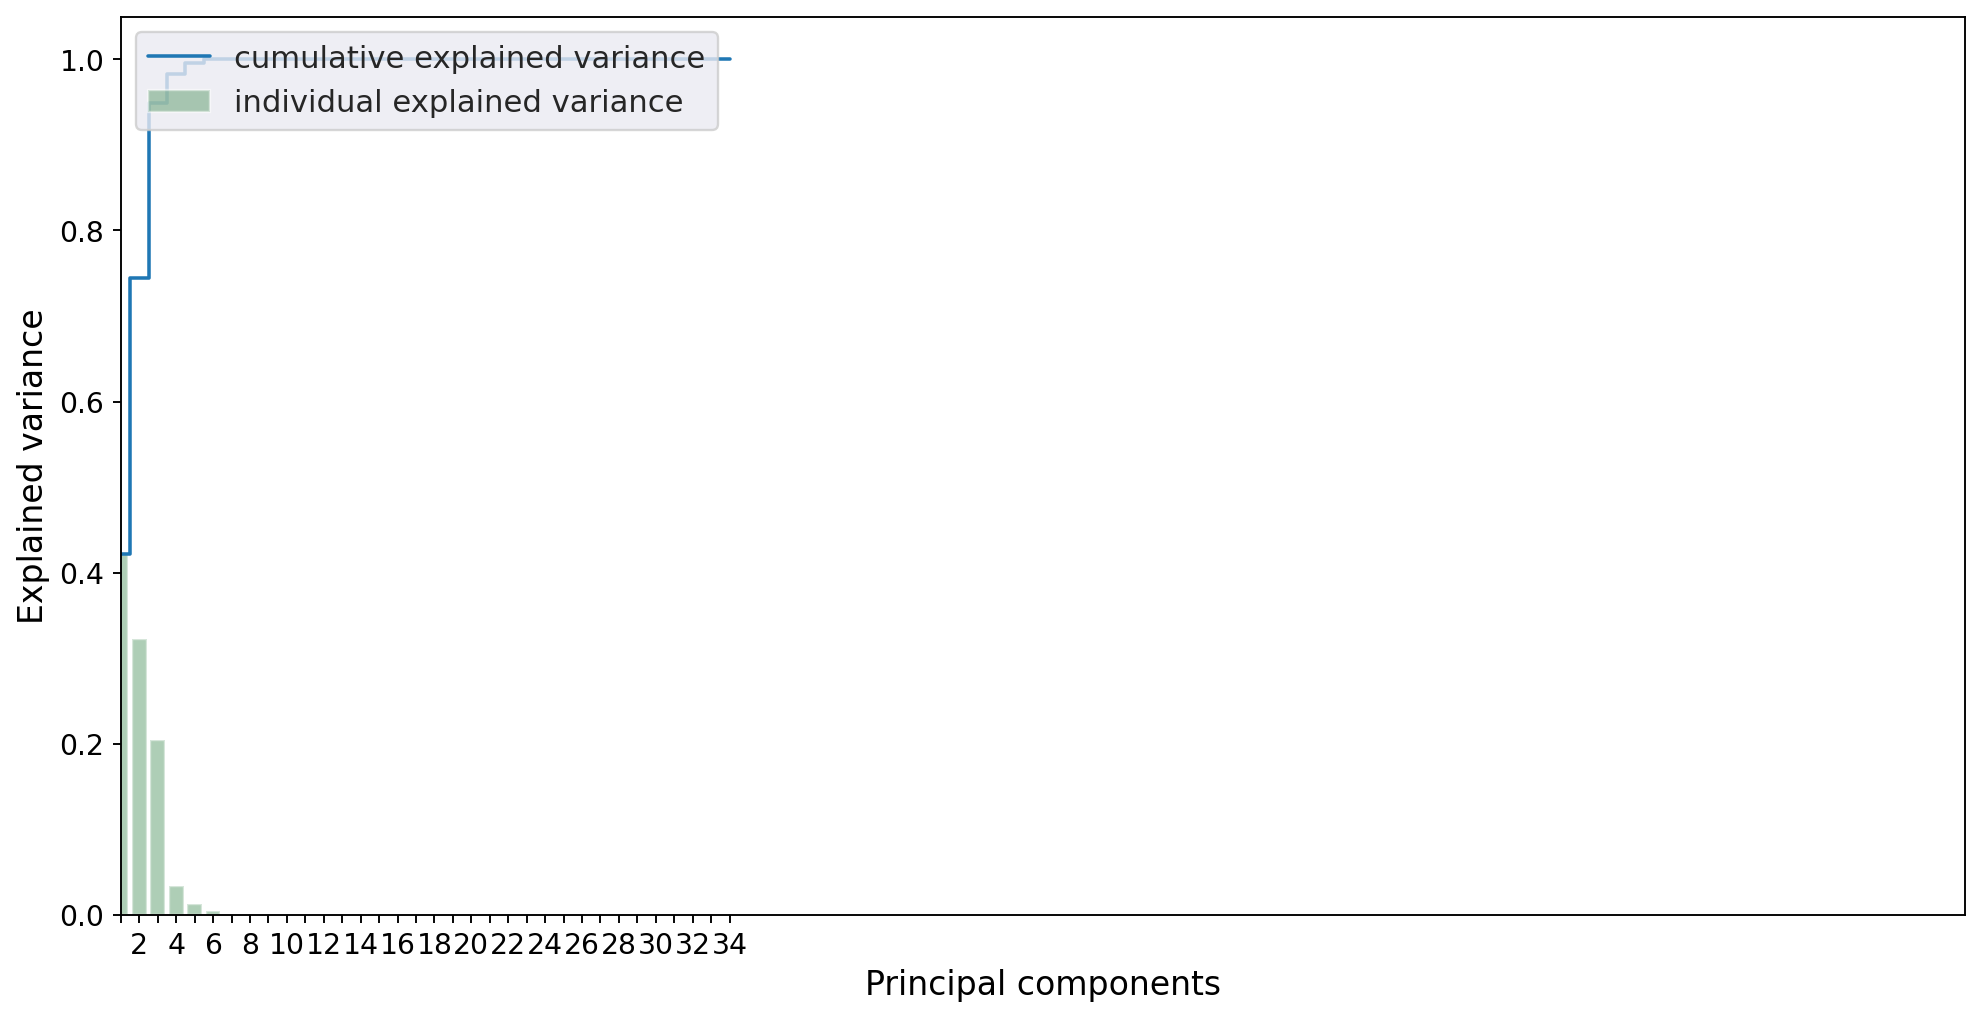

In [104]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns

from sklearn.model_selection import StratifiedKFold
condition_2_3 = (
((df_tto_re_pv['TRO_NET 2021-09'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-10'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-11'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-12'] == 0)) | \
    
((df_tto_re_pv['TRO_NET 2021-09'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-10'] == 0) & \
(df_tto_re_pv['TRO_NET 2021-11'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-12'] == 0)) |
    
((df_tto_re_pv['TRO_NET 2021-09'] == 0) & \
(df_tto_re_pv['TRO_NET 2021-10'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-11'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-12'] == 0))
)

df_tto_re_pv['label'] = np.where(condition_2_3, 1, 0)


X = df_tto_re_pv.drop(
[
'TRO_MEMBERS',
'TRO_NET 2021-12', 
'TRO_NO_ORDER 2021-12',
'SLA 2021-12',
'SLA_LATE 2021-12',
'RATING_BELOW 2021-12',
'RATING_AVG 2021-12',
'PV 2021-12',
'TRO_VOUCHER_USAGE 2021-12',
'TRO_PAYMENT_METHOD 2021-12',
'label'
], 1
)
y = df_tto_re_pv[['label']]
matrix = X.iloc[:,0:].copy()
pca = PCA()
pca.fit(matrix)
pca_samples = pca.transform(matrix)

fig, ax = plt.subplots(figsize=(14, 7), dpi=170)
sns.set(font_scale=1)
plt.step(range(matrix.shape[1]), pca.explained_variance_ratio_.cumsum(), where='mid',
         label='cumulative explained variance')
sns.barplot(np.arange(1,matrix.shape[1]+1), pca.explained_variance_ratio_, alpha=0.5, color = 'g',
            label='individual explained variance')
plt.xlim(0, 100)

ax.set_xticklabels([s if int(s.get_text())%2 == 0 else '' for s in ax.get_xticklabels()])

plt.ylabel('Explained variance', fontsize = 14)
plt.xlabel('Principal components', fontsize = 14)
plt.legend(loc='upper left', fontsize = 13);

              precision    recall  f1-score   support

           0       0.93      0.99      0.96     95914
           1       0.53      0.15      0.23      8590

    accuracy                           0.92    104504
   macro avg       0.73      0.57      0.60    104504
weighted avg       0.90      0.92      0.90    104504

              precision    recall  f1-score   support

           0       0.92      0.99      0.96     95914
           1       0.58      0.10      0.17      8589

    accuracy                           0.92    104503
   macro avg       0.75      0.55      0.56    104503
weighted avg       0.90      0.92      0.89    104503

              precision    recall  f1-score   support

           0       0.93      0.98      0.95     95914
           1       0.43      0.16      0.24      8589

    accuracy                           0.91    104503
   macro avg       0.68      0.57      0.60    104503
weighted avg       0.89      0.91      0.90    104503

              preci

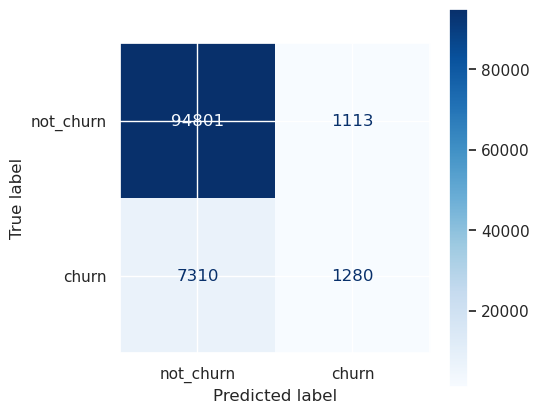

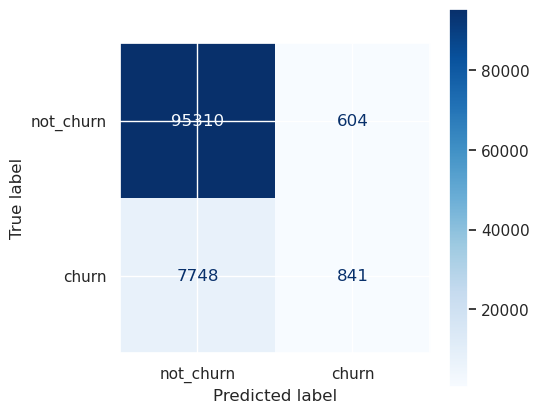

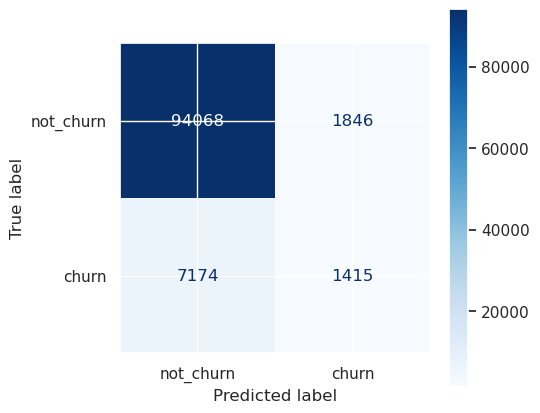

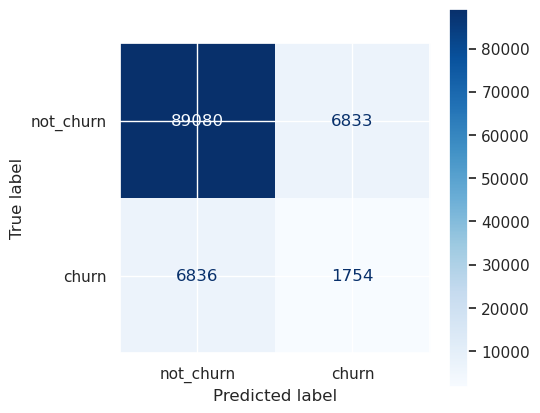

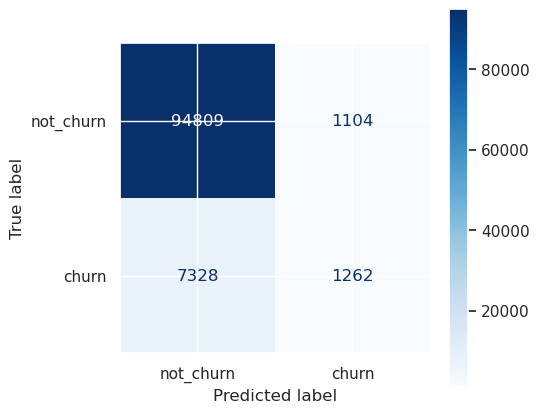

In [117]:
from sklearn.ensemble import HistGradientBoostingClassifier


from sklearn.model_selection import StratifiedKFold
condition_2_3 = (
((df_tto_re_pv['TRO_NET 2021-09'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-10'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-11'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-12'] == 0)) | \
    
((df_tto_re_pv['TRO_NET 2021-09'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-10'] == 0) & \
(df_tto_re_pv['TRO_NET 2021-11'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-12'] == 0)) |
    
((df_tto_re_pv['TRO_NET 2021-09'] == 0) & \
(df_tto_re_pv['TRO_NET 2021-10'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-11'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-12'] == 0))
)

df_tto_re_pv['label'] = np.where(condition_2_3, 1, 0)


X = df_tto_re_pv.drop(
[
'TRO_MEMBERS',
'TRO_NET 2021-12', 
'TRO_NO_ORDER 2021-12',
'SLA 2021-12',
'SLA_LATE 2021-12',
'RATING_BELOW 2021-12',
'RATING_AVG 2021-12',
'PV 2021-12',
'TRO_VOUCHER_USAGE 2021-12',
'TRO_PAYMENT_METHOD 2021-12',
'label'
], 1
)
y = df_tto_re_pv[['label']]



skf = StratifiedKFold(n_splits=5)
for train_index, test_index in skf.split(X, y):
    print("="*50)
    X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
    y_train, y_test = y.iloc[train_index,:], y.iloc[test_index,:]

    
    ## applying standard scaler
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train = pd.DataFrame(scaler.transform(X_train), index=X_train.index, columns=X_train.columns)
    X_test = pd.DataFrame(scaler.transform(X_test), index=X_test.index, columns=X_train.columns)
    


    clf_ridge = HistGradientBoostingClassifier()
    clf_ridge.fit(X_train, y_train) 
    pred = clf_ridge.predict(X_test)

    print(classification_report(y_test, pred))
    fig, ax = plt.subplots(figsize=(5, 5), dpi=100)
    ConfusionMatrixDisplay.from_predictions(y_test, pred, 
                                            cmap='Blues', display_labels= ['not_churn', 'churn'], 
                                            ax = ax, values_format = 'd')



### RANDOM FOREST

### not oversampling version without threshold 2/3

              precision    recall  f1-score   support

           0       0.92      1.00      0.96     95914
           1       0.00      0.00      0.00      8590

    accuracy                           0.92    104504
   macro avg       0.46      0.50      0.48    104504
weighted avg       0.84      0.92      0.88    104504

              precision    recall  f1-score   support

           0       0.92      1.00      0.96     95914
           1       0.00      0.00      0.00      8589

    accuracy                           0.92    104503
   macro avg       0.46      0.50      0.48    104503
weighted avg       0.84      0.92      0.88    104503

              precision    recall  f1-score   support

           0       0.92      1.00      0.96     95914
           1       0.11      0.00      0.00      8589

    accuracy                           0.92    104503
   macro avg       0.51      0.50      0.48    104503
weighted avg       0.85      0.92      0.88    104503

              preci

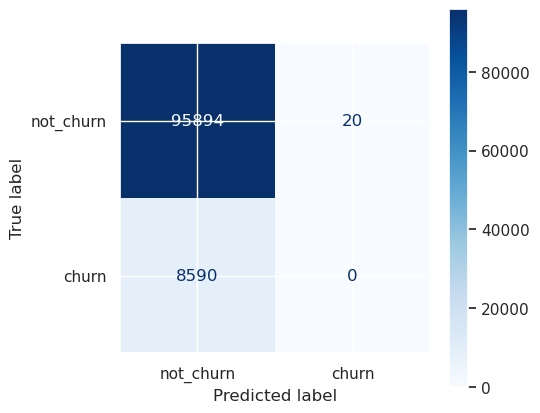

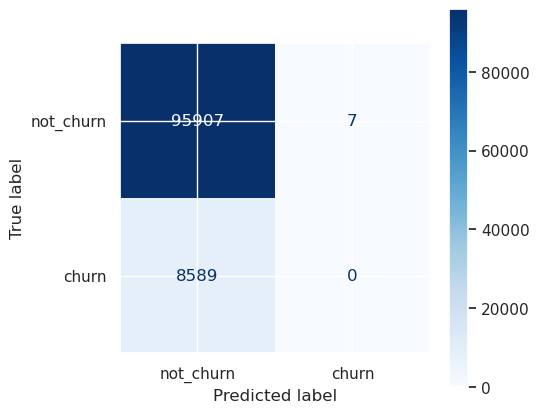

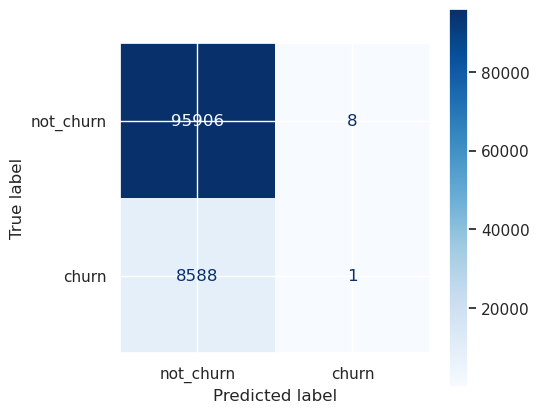

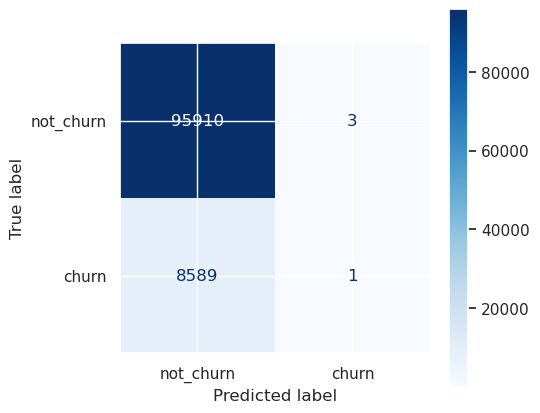

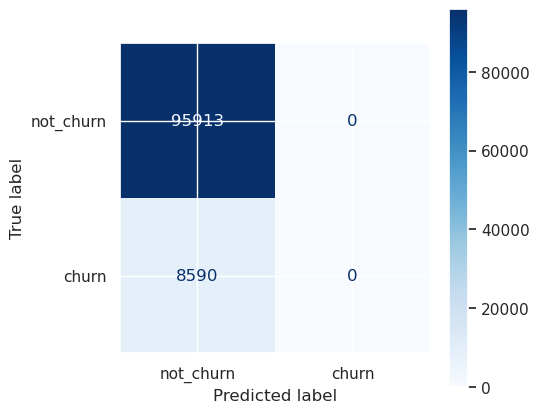

In [112]:
from sklearn.model_selection import StratifiedKFold
condition_2_3 = (
((df_tto_re_pv['TRO_NET 2021-09'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-10'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-11'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-12'] == 0)) | \
    
((df_tto_re_pv['TRO_NET 2021-09'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-10'] == 0) & \
(df_tto_re_pv['TRO_NET 2021-11'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-12'] == 0)) |
    
((df_tto_re_pv['TRO_NET 2021-09'] == 0) & \
(df_tto_re_pv['TRO_NET 2021-10'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-11'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-12'] == 0))
)

df_tto_re_pv['label'] = np.where(condition_2_3, 1, 0)


X = df_tto_re_pv.drop(
[
'TRO_MEMBERS',
'TRO_NET 2021-12', 
'TRO_NO_ORDER 2021-12',
'SLA 2021-12',
'SLA_LATE 2021-12',
'RATING_BELOW 2021-12',
'RATING_AVG 2021-12',
'PV 2021-12',
'TRO_VOUCHER_USAGE 2021-12',
'TRO_PAYMENT_METHOD 2021-12',
'label'
], 1
)
y = df_tto_re_pv[['label']]



skf = StratifiedKFold(n_splits=5)
for train_index, test_index in skf.split(X, y):
    print("="*50)
    X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
    y_train, y_test = y.iloc[train_index,:], y.iloc[test_index,:]

    #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0, stratify=y)
    
    ## applying standard scaler
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train = pd.DataFrame(scaler.transform(X_train), index=X_train.index, columns=X_train.columns)
    X_test = pd.DataFrame(scaler.transform(X_test), index=X_test.index, columns=X_train.columns)
    

#     ## applying pca
#     n_comp = 5

#     pca = PCA(n_components=n_comp)
#     pca.fit(X_train)
#     X_train = pd.DataFrame(pca.transform(X_train), columns=(['col{}'.format(i) for i in range(1,n_comp+1)]))
#     X_test = pd.DataFrame(pca.transform(X_test), columns=(['col{}'.format(i) for i in range(1,n_comp+1)]))

#     clf_ridge = RandomForestClassifier(random_state=42) 
    clf_ridge = LinearSVC(C=0.01, penalty="l1", dual=False)
    clf_ridge.fit(X_train, y_train) 
    pred = clf_ridge.predict(X_test)
#     pred = (clf_ridge.predict_proba(X_test)[:,1] >= 0.5).astype(int)
    print(classification_report(y_test, pred))
    fig, ax = plt.subplots(figsize=(5, 5), dpi=100)
    ConfusionMatrixDisplay.from_predictions(y_test, pred, 
                                            cmap='Blues', display_labels= ['not_churn', 'churn'], 
                                            ax = ax, values_format = 'd')



In [110]:
df_tto_re_pv[df_tto_re_pv['label'] == 1].head(50)

,TRO_MEMBERS,TRO_NET 2021-09,TRO_NET 2021-10,TRO_NET 2021-11,TRO_NET 2021-12,TRO_NO_ORDER 2021-09,TRO_NO_ORDER 2021-10,TRO_NO_ORDER 2021-11,TRO_NO_ORDER 2021-12,SLA 2021-09,SLA 2021-10,SLA 2021-11,SLA 2021-12,SLA_LATE 2021-09,SLA_LATE 2021-10,SLA_LATE 2021-11,SLA_LATE 2021-12,TRO_VOUCHER_USAGE 2021-09,TRO_VOUCHER_USAGE 2021-10,TRO_VOUCHER_USAGE 2021-11,TRO_VOUCHER_USAGE 2021-12,TRO_PAYMENT_METHOD 2021-09,TRO_PAYMENT_METHOD 2021-10,TRO_PAYMENT_METHOD 2021-11,TRO_PAYMENT_METHOD 2021-12,RATING_BELOW 2021-09,RATING_BELOW 2021-10,RATING_BELOW 2021-11,RATING_BELOW 2021-12,RATING_AVG 2021-09,RATING_AVG 2021-10,RATING_AVG 2021-11,RATING_AVG 2021-12,PV 2021-09,PV 2021-10,PV 2021-11,PV 2021-12,SINCE_REGIS,NET_11-10,NET_10-09,NET_11-09,STRUK_11-10,STRUK_10-09,STRUK_11-09,label
19,9990010000079873,565660.0,150542.0,129998.0,0.0,18.0,3.0,2.0,0.0,4725.5,31.1,30.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.0,8.0,0.0,2.0,922.0,-20544.0,-415118.0,-435662.0,-1.0,-15.0,-16.0,1
27,9990010000107760,206812.0,191632.0,67635.0,0.0,3.0,2.0,1.0,0.0,71.8,33.2,73.7,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,167.0,-123997.0,-15180.0,-139177.0,-1.0,-1.0,-2.0,1
42,9990010000191790,297814.0,55000.0,126817.0,0.0,2.0,1.0,1.0,0.0,27.8,25.6,23.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,5.0,0.0,1.0,10.0,2.0,7.0,376.0,71817.0,-242814.0,-170997.0,0.0,-1.0,-1.0,1
43,9990010000196641,377351.0,47179.0,48543.0,0.0,5.0,1.0,1.0,0.0,100.2,16.7,14.4,0.0,0.0,0.0,0.0,0.0,987000.0,0.0,0.0,0.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,5.0,5.0,0.0,0.0,12.0,2.0,4.0,2.0,260.0,1364.0,-330172.0,-328808.0,0.0,-4.0,-4.0,1
45,9990010000198325,109816.0,0.0,259360.0,0.0,1.0,0.0,1.0,0.0,7.8,0.0,13.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,10.0,9.0,251.0,259360.0,-109816.0,149544.0,1.0,-1.0,0.0,1
57,9990010000205973,386600.0,600100.0,756900.0,0.0,2.0,2.0,2.0,0.0,5096.6,4066.5,3002.0,0.0,2.0,2.0,2.0,0.0,0.0,0.0,60000.0,0.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,12.0,0.0,239.0,156800.0,213500.0,370300.0,0.0,0.0,0.0,1
74,9990010000218924,197722.0,213723.0,292724.0,0.0,1.0,1.0,1.0,0.0,3.4,7.0,1778.5,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,1.0,2.0,0.0,239.0,79001.0,16001.0,95002.0,0.0,0.0,0.0,1
75,9990010000222616,0.0,243586.0,42953.0,0.0,0.0,3.0,1.0,0.0,0.0,25.0,8.7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,10.0,13.0,3.0,585.0,-200633.0,243586.0,42953.0,-2.0,3.0,1.0,1
92,9990010000262436,323177.0,273990.0,104269.0,0.0,1.0,3.0,1.0,0.0,1545.6,36.5,27.7,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.0,8.0,33.0,19.0,237.0,-169721.0,-49187.0,-218908.0,-2.0,2.0,0.0,1
96,9990010000292942,222628.0,316990.0,156088.0,0.0,2.0,2.0,1.0,0.0,299.0,20.2,10.5,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,19.0,7.0,2.0,381.0,-160902.0,94362.0,-66540.0,-1.0,0.0,-1.0,1


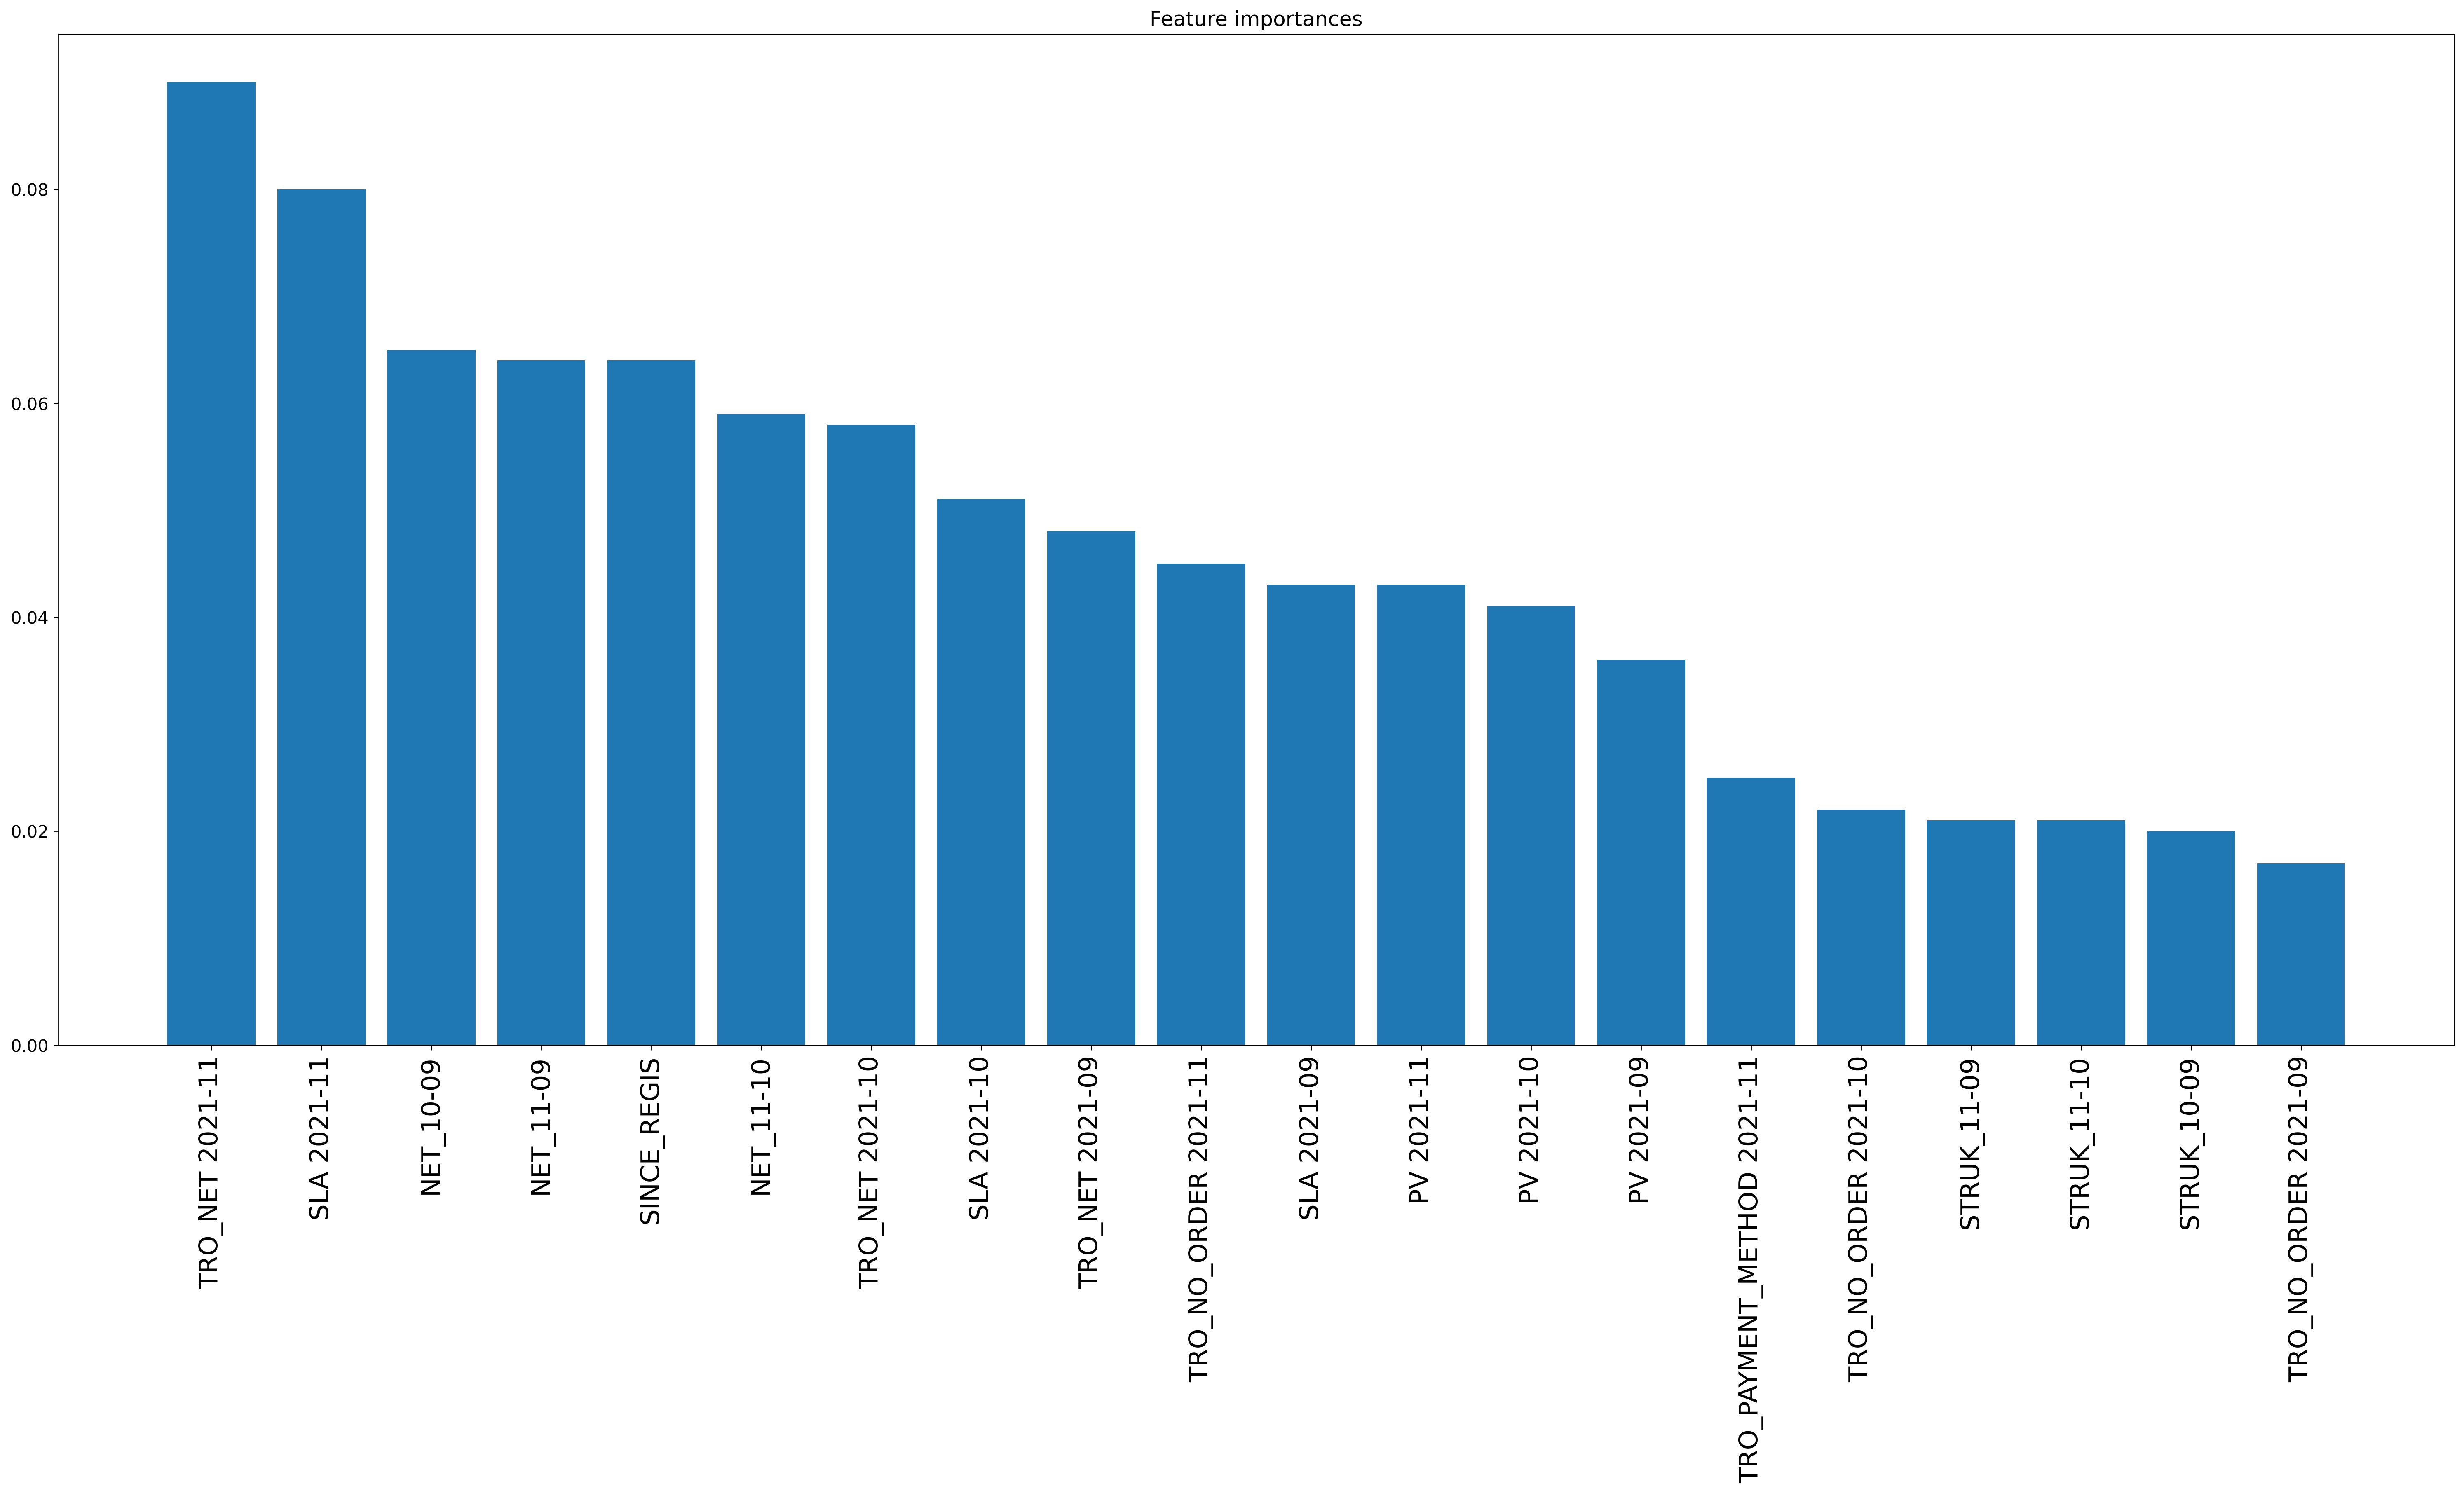

In [103]:
importances = pd.DataFrame({'feature':X.columns,'importance':np.round(clf_ridge.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
importances = importances[0:20]
x_range = list(range(importances.shape[0]))
x_plot = list(importances.index)
y_plot = list(importances["importance"])
plt.figure(figsize=(30,13), dpi=250)
plt.title("Feature importances")
plt.bar(x_range, y_plot)
plt.xticks(x_range, x_plot, rotation='vertical', fontsize=18)
fig = plt.gcf()


### not oversampling version without threshold 3/3

              precision    recall  f1-score   support

           0       0.97      1.00      0.98    166631
           1       0.49      0.07      0.12      5800

    accuracy                           0.97    172431
   macro avg       0.73      0.53      0.55    172431
weighted avg       0.95      0.97      0.95    172431



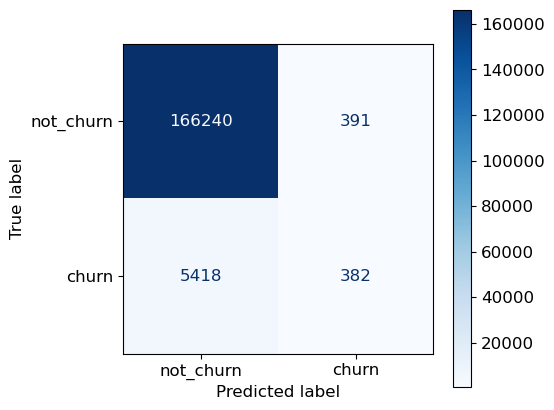

In [52]:
condition_3_3 = ( 
          (df_tto_re_pv['TRO_NET 2021-09'] > 0) & \
          (df_tto_re_pv['TRO_NET 2021-10'] > 0) & \
          (df_tto_re_pv['TRO_NET 2021-11'] > 0) & \
          (df_tto_re_pv['TRO_NET 2021-12'] == 0) 
)
df_tto_re_pv['label'] = np.where(condition_3_3, 1, 0)

X = df_tto_re_pv.drop(
[
'TRO_MEMBERS',
'TRO_NET 2021-12', 
'TRO_NO_ORDER 2021-12',
'SLA 2021-12',
'SLA_LATE 2021-12',
'RATING_BELOW 2021-12',
'RATING_AVG 2021-12',
'PV 2021-12',
'TRO_VOUCHER_USAGE 2021-12',
'TRO_PAYMENT_METHOD 2021-12',
'label'
], 1
)
y = df_tto_re_pv['label']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)

scaler = StandardScaler()
scaler.fit(X_train)
X_train = pd.DataFrame(scaler.transform(X_train), index=X_train.index, columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), index=X_test.index, columns=X_train.columns)

clf_ridge = RandomForestClassifier(random_state=42) 
clf_ridge.fit(X_train, y_train) 
# pred_proba = clf_ridge.predict_proba(X_test)
pred = (clf_ridge.predict_proba(X_test)[:,1] >= 0.5).astype(int)
print(classification_report(y_test, pred))
fig, ax = plt.subplots(figsize=(5, 5), dpi=100)
ConfusionMatrixDisplay.from_predictions(y_test, pred, 
                                        cmap='Blues', display_labels= ['not_churn', 'churn'], 
                                        ax = ax, values_format = 'd')

In [ ]:
df_res = pd.concat([
    pd.concat([df_tto_re_pv.drop(['label'],1).loc[X_test.index, :].reset_index(drop=True), pd.DataFrame({'pred':pred})],1), 
    y_test.reset_index(drop=True)],1)

In [ ]:
df_res[(df_res['label'] == 0) & (df_res['pred'] == 1)].head(10)

In [ ]:
df_res[(df_res['label'] == 1) & (df_res['pred'] == 0)].head(10)

## rf oversampling version 2/3

              precision    recall  f1-score   support

           0       0.96      0.93      0.94     95914
           1       0.40      0.52      0.45      8590

    accuracy                           0.90    104504
   macro avg       0.68      0.72      0.70    104504
weighted avg       0.91      0.90      0.90    104504



              precision    recall  f1-score   support

           0       0.95      0.95      0.95     95914
           1       0.44      0.47      0.45      8589

    accuracy                           0.91    104503
   macro avg       0.70      0.71      0.70    104503
weighted avg       0.91      0.91      0.91    104503



              precision    recall  f1-score   support

           0       0.96      0.93      0.94     95914
           1       0.39      0.54      0.45      8589

    accuracy                           0.89    104503
   macro avg       0.67      0.73      0.70    104503
weighted avg       0.91      0.89      0.90    104503



KeyboardInterrupt: 

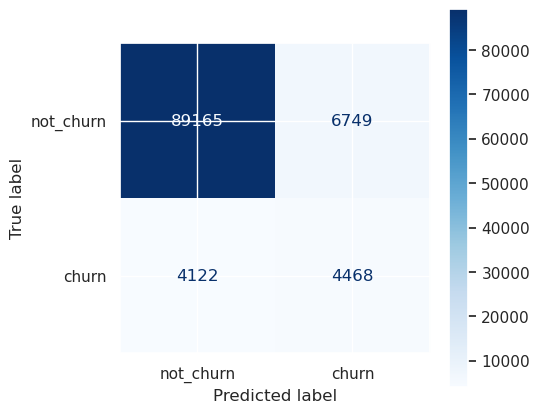

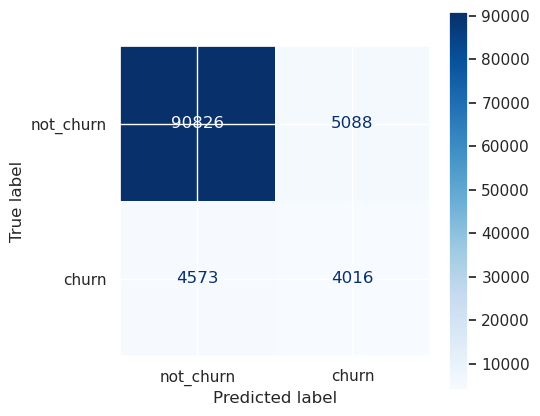

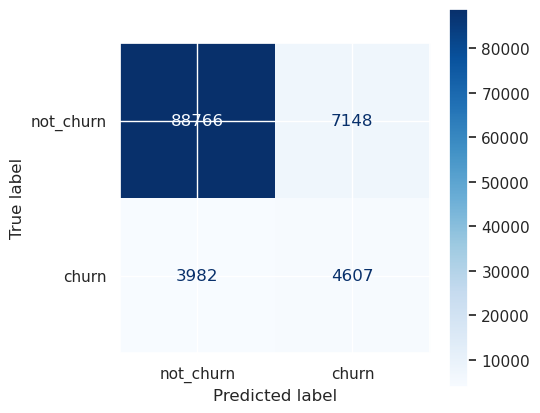

In [116]:
condition_2_3 = (
((df_tto_re_pv['TRO_NET 2021-09'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-10'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-11'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-12'] == 0)) | \
    
((df_tto_re_pv['TRO_NET 2021-09'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-10'] == 0) & \
(df_tto_re_pv['TRO_NET 2021-11'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-12'] == 0)) |
    
((df_tto_re_pv['TRO_NET 2021-09'] == 0) & \
(df_tto_re_pv['TRO_NET 2021-10'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-11'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-12'] == 0))
)

df_tto_re_pv['label'] = np.where(condition_2_3, 1, 0)


X = df_tto_re_pv.drop(
[
'TRO_MEMBERS',
'TRO_NET 2021-12', 
'TRO_NO_ORDER 2021-12',
'SLA 2021-12',
'SLA_LATE 2021-12',
'RATING_BELOW 2021-12',
'RATING_AVG 2021-12',
'PV 2021-12',
'TRO_VOUCHER_USAGE 2021-12',
'TRO_PAYMENT_METHOD 2021-12',
'label'
], 1
)
y = df_tto_re_pv['label']

from sklearn.model_selection import StratifiedKFold
condition_2_3 = (
((df_tto_re_pv['TRO_NET 2021-09'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-10'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-11'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-12'] == 0)) | \
    
((df_tto_re_pv['TRO_NET 2021-09'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-10'] == 0) & \
(df_tto_re_pv['TRO_NET 2021-11'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-12'] == 0)) |
    
((df_tto_re_pv['TRO_NET 2021-09'] == 0) & \
(df_tto_re_pv['TRO_NET 2021-10'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-11'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-12'] == 0))
)

df_tto_re_pv['label'] = np.where(condition_2_3, 1, 0)


X = df_tto_re_pv.drop(
[
'TRO_MEMBERS',
'TRO_NET 2021-12', 
'TRO_NO_ORDER 2021-12',
'SLA 2021-12',
'SLA_LATE 2021-12',
'RATING_BELOW 2021-12',
'RATING_AVG 2021-12',
'PV 2021-12',
'TRO_VOUCHER_USAGE 2021-12',
'TRO_PAYMENT_METHOD 2021-12',
'label'
], 1
)
y = df_tto_re_pv[['label']]



skf = StratifiedKFold(n_splits=5)
for train_index, test_index in skf.split(X, y):
    print("="*50)
    X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
    y_train, y_test = y.iloc[train_index,:], y.iloc[test_index,:]



    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train = pd.DataFrame(scaler.transform(X_train), index=X_train.index)
    X_test = pd.DataFrame(scaler.transform(X_test), index=X_test.index)


    from imblearn.over_sampling import SMOTE
    oversampler = SMOTE(random_state=0)
    X_train ,y_train = oversampler.fit_resample(X_train, y_train)


    clf_ridge = RandomForestClassifier(n_jobs=32) 
    clf_ridge.fit(X_train, y_train) 
    # pred = clf_ridge.predict(X_test)
    pred = (clf_ridge.predict_proba(X_test)[:,1] >= 0.5).astype(int)


    print(classification_report(y_test, pred))
    fig, ax = plt.subplots(figsize=(5, 5), dpi=100)
    display(ConfusionMatrixDisplay.from_predictions(y_test, pred, 
                                            cmap='Blues', display_labels= ['not_churn', 'churn'], 
                                            ax = ax, values_format = 'd'))

## rf over oversampling 3/3

              precision    recall  f1-score   support

           0       0.98      0.98      0.98    166631
           1       0.36      0.35      0.35      5800

    accuracy                           0.96    172431
   macro avg       0.67      0.66      0.67    172431
weighted avg       0.96      0.96      0.96    172431



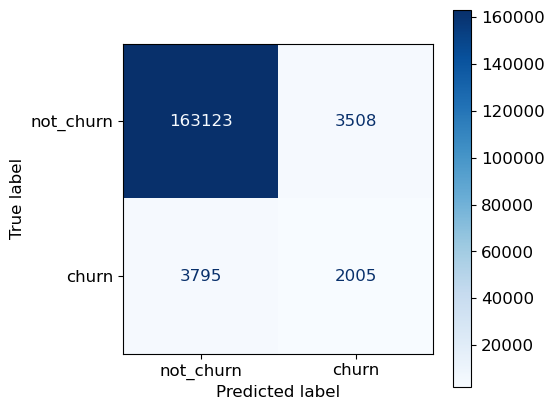

In [54]:
condition_3_3 = ( 
          (df_tto_re_pv['TRO_NET 2021-09'] > 0) & \
          (df_tto_re_pv['TRO_NET 2021-10'] > 0) & \
          (df_tto_re_pv['TRO_NET 2021-11'] > 0) & \
          (df_tto_re_pv['TRO_NET 2021-12'] == 0) 
)
df_tto_re_pv['label'] = np.where(condition_3_3, 1, 0)


X = df_tto_re_pv.drop(
[
'TRO_MEMBERS',
'TRO_NET 2021-12', 
'TRO_NO_ORDER 2021-12',
'SLA 2021-12',
'SLA_LATE 2021-12',
'RATING_BELOW 2021-12',
'RATING_AVG 2021-12',
'PV 2021-12',
'TRO_VOUCHER_USAGE 2021-12',
'TRO_PAYMENT_METHOD 2021-12',
'label'
], 1
)
y = df_tto_re_pv['label']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)

scaler = StandardScaler()
scaler.fit(X_train)
X_train = pd.DataFrame(scaler.transform(X_train), index=X_train.index)
X_test = pd.DataFrame(scaler.transform(X_test), index=X_test.index)


from imblearn.over_sampling import SMOTE
oversampler = SMOTE(random_state=0)
X_train ,y_train = oversampler.fit_resample(X_train, y_train)


clf_ridge = RandomForestClassifier(n_jobs=32) 
clf_ridge.fit(X_train, y_train) 
# pred = clf_ridge.predict(X_test)
pred = (clf_ridge.predict_proba(X_test)[:,1] >= 0.5).astype(int)


print(classification_report(y_test, pred))
fig, ax = plt.subplots(figsize=(5, 5), dpi=100)
ConfusionMatrixDisplay.from_predictions(y_test, pred, 
                                        cmap='Blues', display_labels= ['not_churn', 'churn'], 
                                        ax = ax, values_format = 'd')

In [ ]:
df_res = pd.concat([
    pd.concat([df_tto_re_pv.drop(['label'],1).loc[X_test.index, :].reset_index(drop=True), pd.DataFrame({'pred':pred})],1), 
    y_test.reset_index(drop=True)],1)

In [ ]:
df_res[(df_res['label'] == 0) & (df_res['pred'] == 1)].head(10)

In [ ]:
df_res[(df_res['label'] == 1) & (df_res['pred'] == 0)].head(10)

## XGBOOST

### not oversampling 2/3

[16:12:50] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       0.93      0.99      0.96     95914
           1       0.54      0.13      0.21      8590

    accuracy                           0.92    104504
   macro avg       0.73      0.56      0.59    104504
weighted avg       0.90      0.92      0.90    104504

[16:13:10] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       0.92      0.99      0.96     95914
           1       0.57      0.09      0.15      8589

    a

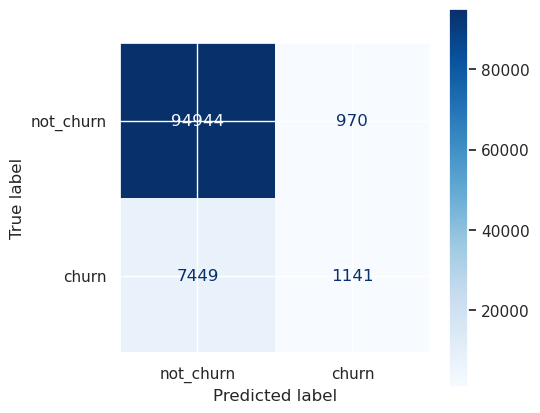

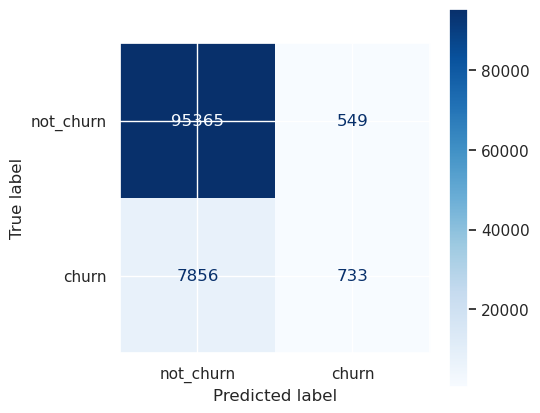

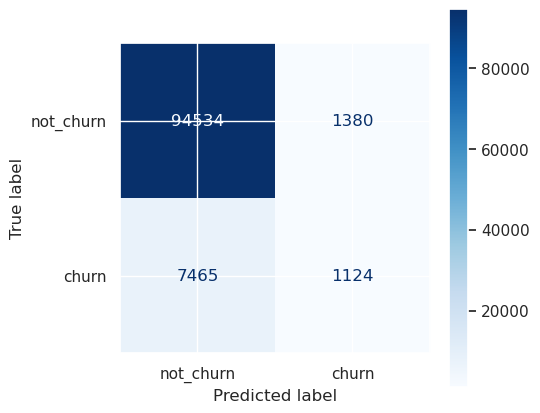

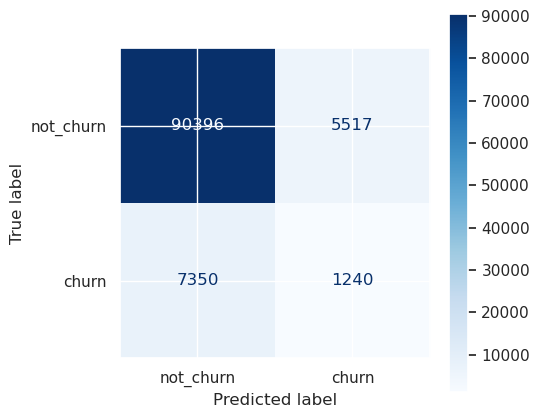

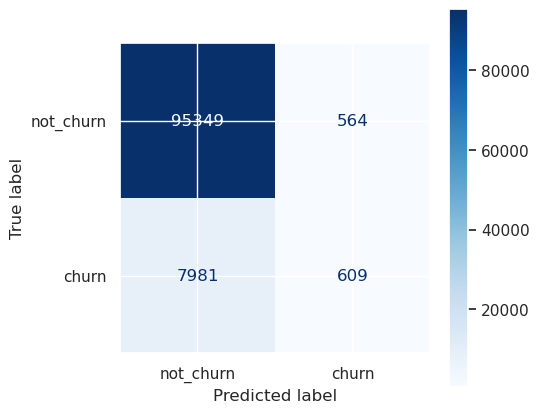

In [119]:
from sklearn.model_selection import StratifiedKFold
condition_2_3 = (
((df_tto_re_pv['TRO_NET 2021-09'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-10'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-11'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-12'] == 0)) | \
    
((df_tto_re_pv['TRO_NET 2021-09'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-10'] == 0) & \
(df_tto_re_pv['TRO_NET 2021-11'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-12'] == 0)) |
    
((df_tto_re_pv['TRO_NET 2021-09'] == 0) & \
(df_tto_re_pv['TRO_NET 2021-10'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-11'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-12'] == 0))
)

df_tto_re_pv['label'] = np.where(condition_2_3, 1, 0)


X = df_tto_re_pv.drop(
[
'TRO_MEMBERS',
'TRO_NET 2021-12', 
'TRO_NO_ORDER 2021-12',
'SLA 2021-12',
'SLA_LATE 2021-12',
'RATING_BELOW 2021-12',
'RATING_AVG 2021-12',
'PV 2021-12',
'TRO_VOUCHER_USAGE 2021-12',
'TRO_PAYMENT_METHOD 2021-12',
'label'
], 1
)
y = df_tto_re_pv[['label']]


skf = StratifiedKFold(n_splits=5)
for train_index, test_index in skf.split(X, y):
    print("="*50)
    X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
    y_train, y_test = y.iloc[train_index,:], y.iloc[test_index,:]

    
    ## applying standard scaler
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train = pd.DataFrame(scaler.transform(X_train), index=X_train.index, columns=X_train.columns)
    X_test = pd.DataFrame(scaler.transform(X_test), index=X_test.index, columns=X_train.columns)
    


    clf_ridge = xgb.XGBClassifier(max_depth=5, learning_rate=0.08, objective= 'binary:logistic',n_jobs=-1)
    clf_ridge.fit(X_train, y_train) 
    pred = clf_ridge.predict(X_test)

    print(classification_report(y_test, pred))
    fig, ax = plt.subplots(figsize=(5, 5), dpi=100)
    ConfusionMatrixDisplay.from_predictions(y_test, pred, 
                                            cmap='Blues', display_labels= ['not_churn', 'churn'], 
                                            ax = ax, values_format = 'd')



In [118]:
# condition_2_3 = (
# ((df_tto_re_pv['TRO_NET 2021-09'] > 0) & \
# (df_tto_re_pv['TRO_NET 2021-10'] > 0) & \
# (df_tto_re_pv['TRO_NET 2021-11'] > 0) & \
# (df_tto_re_pv['TRO_NET 2021-12'] == 0)) | \
    
# ((df_tto_re_pv['TRO_NET 2021-09'] > 0) & \
# (df_tto_re_pv['TRO_NET 2021-10'] == 0) & \
# (df_tto_re_pv['TRO_NET 2021-11'] > 0) & \
# (df_tto_re_pv['TRO_NET 2021-12'] == 0)) |
    
# ((df_tto_re_pv['TRO_NET 2021-09'] == 0) & \
# (df_tto_re_pv['TRO_NET 2021-10'] > 0) & \
# (df_tto_re_pv['TRO_NET 2021-11'] > 0) & \
# (df_tto_re_pv['TRO_NET 2021-12'] == 0))
# )

# df_tto_re_pv['label'] = np.where(condition_2_3, 1, 0)


# X = df_tto_re_pv.drop(
# [
# 'TRO_MEMBERS',
# 'TRO_NET 2021-12', 
# 'TRO_NO_ORDER 2021-12',
# 'SLA 2021-12',
# 'SLA_LATE 2021-12',
# 'RATING_BELOW 2021-12',
# 'RATING_AVG 2021-12',
# 'PV 2021-12',
# 'TRO_VOUCHER_USAGE 2021-12',
# 'TRO_PAYMENT_METHOD 2021-12',
# 'label'
# ], 1
# )
# y = df_tto_re_pv['label']


# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)

# scaler = StandardScaler()
# scaler.fit(X_train)
# X_train = pd.DataFrame(scaler.transform(X_train), index=X_train.index, columns=X_train.columns)
# X_test = pd.DataFrame(scaler.transform(X_test), index=X_test.index, columns=X_train.columns)

# clf_ridge = xgb.XGBClassifier(max_depth=5, learning_rate=0.08, objective= 'binary:logistic',n_jobs=-1)
# clf_ridge.fit(X_train, y_train) 
# # pred_proba = clf_ridge.predict_proba(X_test)
# pred = (clf_ridge.predict_proba(X_test)[:,1] >= 0.5).astype(int)
# print(classification_report(y_test, pred))
# fig, ax = plt.subplots(figsize=(5, 5), dpi=100)
# ConfusionMatrixDisplay.from_predictions(y_test, pred, 
#                                         cmap='Blues', display_labels= ['not_churn', 'churn'], 
#                                         ax = ax, values_format = 'd')


### not oversampling version 3/3

In [ ]:
condition_3_3 = ( 
          (df_tto_re_pv['TRO_NET 2021-09'] > 0) & \
          (df_tto_re_pv['TRO_NET 2021-10'] > 0) & \
          (df_tto_re_pv['TRO_NET 2021-11'] > 0) & \
          (df_tto_re_pv['TRO_NET 2021-12'] == 0) 
)
df_tto_re_pv['label'] = np.where(condition_3_3, 1, 0)

X = df_tto_re_pv.drop(
[
'TRO_MEMBERS',
'TRO_NET 2021-12', 
'TRO_NO_ORDER 2021-12',
'SLA 2021-12',
'SLA_LATE 2021-12',
'RATING_BELOW 2021-12',
'RATING_AVG 2021-12',
'PV 2021-12',
'label'
], 1
)
y = df_tto_re_pv['label']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)

scaler = StandardScaler()
scaler.fit(X_train)
X_train = pd.DataFrame(scaler.transform(X_train), index=X_train.index, columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), index=X_test.index, columns=X_train.columns)

clf_ridge = RandomForestClassifier(random_state=42) 
clf_ridge.fit(X_train, y_train) 
# pred_proba = clf_ridge.predict_proba(X_test)
pred = (clf_ridge.predict_proba(X_test)[:,1] >= 0.5).astype(int)
print(classification_report(y_test, pred))
fig, ax = plt.subplots(figsize=(5, 5), dpi=100)
ConfusionMatrixDisplay.from_predictions(y_test, pred, 
                                        cmap='Blues', display_labels= ['not_churn', 'churn'], 
                                        ax = ax, values_format = 'd')

# MLP ( 2/3 )

              precision    recall  f1-score   support

           0       0.93      0.98      0.96    158258
           1       0.54      0.21      0.31     14173

    accuracy                           0.92    172431
   macro avg       0.74      0.60      0.63    172431
weighted avg       0.90      0.92      0.90    172431



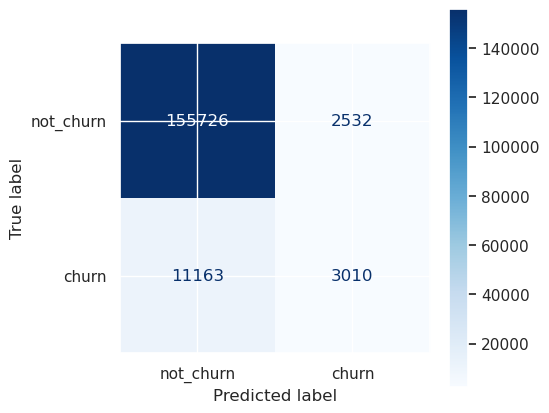

In [114]:
# from sklearn.neural_network import MLPClassifier


# condition_2_3 = (
# ((df_tto_re_pv['TRO_NET 2021-09'] > 0) & \
# (df_tto_re_pv['TRO_NET 2021-10'] > 0) & \
# (df_tto_re_pv['TRO_NET 2021-11'] > 0) & \
# (df_tto_re_pv['TRO_NET 2021-12'] == 0)) | \
    
# ((df_tto_re_pv['TRO_NET 2021-09'] > 0) & \
# (df_tto_re_pv['TRO_NET 2021-10'] == 0) & \
# (df_tto_re_pv['TRO_NET 2021-11'] > 0) & \
# (df_tto_re_pv['TRO_NET 2021-12'] == 0)) |
    
# ((df_tto_re_pv['TRO_NET 2021-09'] == 0) & \
# (df_tto_re_pv['TRO_NET 2021-10'] > 0) & \
# (df_tto_re_pv['TRO_NET 2021-11'] > 0) & \
# (df_tto_re_pv['TRO_NET 2021-12'] == 0))
# )

# df_tto_re_pv['label'] = np.where(condition_2_3, 1, 0)


# X = df_tto_re_pv.drop(
# [
# 'TRO_MEMBERS',
# 'TRO_NET 2021-12', 
# 'TRO_NO_ORDER 2021-12',
# 'SLA 2021-12',
# 'SLA_LATE 2021-12',
# 'RATING_BELOW 2021-12',
# 'RATING_AVG 2021-12',
# 'PV 2021-12',
# 'TRO_VOUCHER_USAGE 2021-12',
# 'TRO_PAYMENT_METHOD 2021-12',
# 'label'
# ], 1
# )
# y = df_tto_re_pv[['label']]



# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)

# scaler = StandardScaler()
# scaler.fit(X_train)
# X_train = pd.DataFrame(scaler.transform(X_train), index=X_train.index, columns=X_train.columns)
# X_test = pd.DataFrame(scaler.transform(X_test), index=X_test.index, columns=X_train.columns)

# clf_ridge = MLPClassifier(random_state=1, max_iter=300, hidden_layer_sizes=(15,))
# clf_ridge.fit(X_train, y_train) 
# # pred_proba = clf_ridge.predict_proba(X_test)
# pred = (clf_ridge.predict_proba(X_test)[:,1] >= 0.5).astype(int)
# print(classification_report(y_test, pred))
# fig, ax = plt.subplots(figsize=(5, 5), dpi=100)
# ConfusionMatrixDisplay.from_predictions(y_test, pred, 
#                                         cmap='Blues', display_labels= ['not_churn', 'churn'], 
#                                         ax = ax, values_format = 'd')


              precision    recall  f1-score   support

           0       0.93      0.99      0.96     95914
           1       0.55      0.13      0.21      8590

    accuracy                           0.92    104504
   macro avg       0.74      0.56      0.58    104504
weighted avg       0.90      0.92      0.90    104504

              precision    recall  f1-score   support

           0       0.92      1.00      0.96     95914
           1       0.58      0.06      0.10      8589

    accuracy                           0.92    104503
   macro avg       0.75      0.53      0.53    104503
weighted avg       0.89      0.92      0.89    104503

              precision    recall  f1-score   support

           0       0.94      0.98      0.96     95914
           1       0.49      0.25      0.33      8589

    accuracy                           0.92    104503
   macro avg       0.71      0.61      0.64    104503
weighted avg       0.90      0.92      0.90    104503

              preci

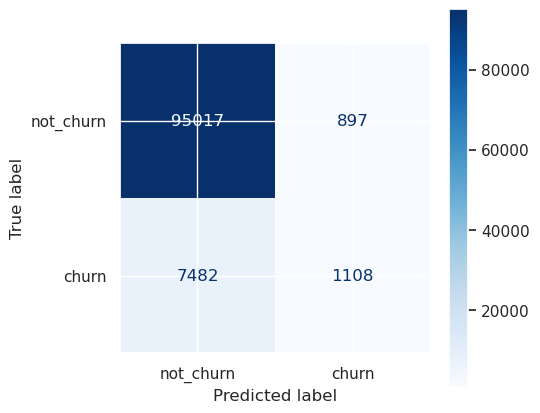

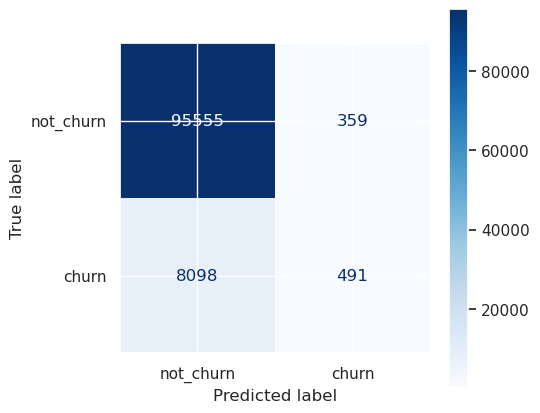

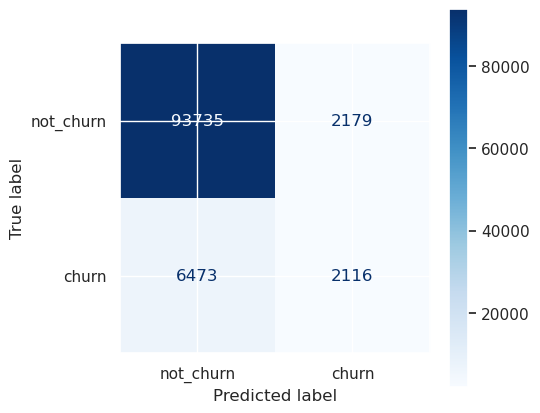

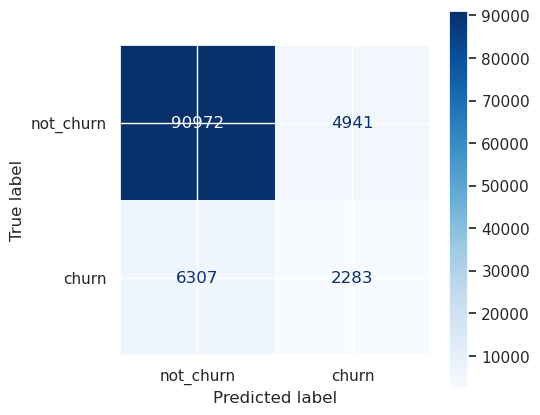

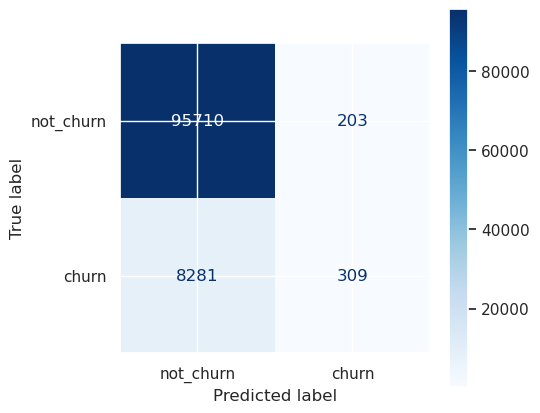

In [120]:
from sklearn.model_selection import StratifiedKFold
condition_2_3 = (
((df_tto_re_pv['TRO_NET 2021-09'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-10'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-11'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-12'] == 0)) | \
    
((df_tto_re_pv['TRO_NET 2021-09'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-10'] == 0) & \
(df_tto_re_pv['TRO_NET 2021-11'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-12'] == 0)) |
    
((df_tto_re_pv['TRO_NET 2021-09'] == 0) & \
(df_tto_re_pv['TRO_NET 2021-10'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-11'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-12'] == 0))
)

df_tto_re_pv['label'] = np.where(condition_2_3, 1, 0)


X = df_tto_re_pv.drop(
[
'TRO_MEMBERS',
'TRO_NET 2021-12', 
'TRO_NO_ORDER 2021-12',
'SLA 2021-12',
'SLA_LATE 2021-12',
'RATING_BELOW 2021-12',
'RATING_AVG 2021-12',
'PV 2021-12',
'TRO_VOUCHER_USAGE 2021-12',
'TRO_PAYMENT_METHOD 2021-12',
'label'
], 1
)
y = df_tto_re_pv[['label']]



skf = StratifiedKFold(n_splits=5)
for train_index, test_index in skf.split(X, y):
    print("="*50)
    X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
    y_train, y_test = y.iloc[train_index,:], y.iloc[test_index,:]

    
    ## applying standard scaler
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train = pd.DataFrame(scaler.transform(X_train), index=X_train.index, columns=X_train.columns)
    X_test = pd.DataFrame(scaler.transform(X_test), index=X_test.index, columns=X_train.columns)
    


    clf_ridge = MLPClassifier(random_state=1, max_iter=300, hidden_layer_sizes=(15,))
    clf_ridge.fit(X_train, y_train) 
    pred = clf_ridge.predict(X_test)

    print(classification_report(y_test, pred))
    fig, ax = plt.subplots(figsize=(5, 5), dpi=100)
    ConfusionMatrixDisplay.from_predictions(y_test, pred, 
                                            cmap='Blues', display_labels= ['not_churn', 'churn'], 
                                            ax = ax, values_format = 'd')



In [ ]:
condition_3_3 = ( 
          (df_tto_re_pv['TRO_NET 2021-09'] > 0) & \
          (df_tto_re_pv['TRO_NET 2021-10'] > 0) & \
          (df_tto_re_pv['TRO_NET 2021-11'] > 0) & \
          (df_tto_re_pv['TRO_NET 2021-12'] == 0) 
)
df_tto_re_pv['label'] = np.where(condition_3_3, 1, 0)

X = df_tto_re_pv.drop(
[
'TRO_MEMBERS',
'TRO_NET 2021-12', 
'TRO_NO_ORDER 2021-12',
'SLA 2021-12',
'SLA_LATE 2021-12',
'RATING_BELOW 2021-12',
'RATING_AVG 2021-12',
'PV 2021-12',
'label'
], 1
)
y = df_tto_re_pv['label']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)

scaler = StandardScaler()
scaler.fit(X_train)
X_train = pd.DataFrame(scaler.transform(X_train), index=X_train.index, columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), index=X_test.index, columns=X_train.columns)

clf_ridge = MLPClassifier(random_state=1, max_iter=300, hidden_layer_sizes=(30,))
clf_ridge.fit(X_train, y_train) 
# pred_proba = clf_ridge.predict_proba(X_test)
pred = (clf_ridge.predict_proba(X_test)[:,1] >= 0.5).astype(int)
print(classification_report(y_test, pred))
fig, ax = plt.subplots(figsize=(5, 5), dpi=100)
ConfusionMatrixDisplay.from_predictions(y_test, pred, 
                                        cmap='Blues', display_labels= ['not_churn', 'churn'], 
                                        ax = ax, values_format = 'd')

## MLP 2/3 oversampling

In [ ]:
from sklearn.neural_network import MLPClassifier


condition_2_3 = (
((df_tto_re_pv['TRO_NET 2021-09'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-10'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-11'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-12'] == 0)) | \
    
((df_tto_re_pv['TRO_NET 2021-09'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-10'] == 0) & \
(df_tto_re_pv['TRO_NET 2021-11'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-12'] == 0)) |
    
((df_tto_re_pv['TRO_NET 2021-09'] == 0) & \
(df_tto_re_pv['TRO_NET 2021-10'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-11'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-12'] == 0))
)

df_tto_re_pv['label'] = np.where(condition_2_3, 1, 0)


X = df_tto_re_pv.drop(
[
'TRO_MEMBERS',
'TRO_NET 2021-12', 
'TRO_NO_ORDER 2021-12',
'SLA 2021-12',
'SLA_LATE 2021-12',
'RATING_BELOW 2021-12',
'RATING_AVG 2021-12',
'PV 2021-12',
'TRO_VOUCHER_USAGE 2021-12',
'TRO_PAYMENT_METHOD 2021-12',
'label'
], 1
)
y = df_tto_re_pv[['label']]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)

# scaler = MinMaxScaler()
scaler = StandardScaler()
scaler.fit(X_train)
X_train = pd.DataFrame(scaler.transform(X_train), index=X_train.index)
X_test = pd.DataFrame(scaler.transform(X_test), index=X_test.index)

from imblearn.over_sampling import SMOTE
oversampler = SMOTE(random_state=0)
X_train ,y_train = oversampler.fit_resample(X_train, y_train)

clf_ridge = MLPClassifier(random_state=1, max_iter=300, hidden_layer_sizes=(30,))
clf_ridge.fit(X_train, y_train) 



# pred = clf_ridge.predict(X_test)
pred = (clf_ridge.predict_proba(X_test)[:,1] >= 0.5).astype(int)
print(classification_report(y_test, pred))
fig, ax = plt.subplots(figsize=(5, 5), dpi=100)
ConfusionMatrixDisplay.from_predictions(y_test, pred, cmap='Blues', display_labels= ['not_churn', 'churn'], ax = ax)

In [ ]:
condition = ( 
          (df_tto_re_pv['TRO_NET 2021-09'] > 0) & \
          (df_tto_re_pv['TRO_NET 2021-10'] > 0) & \
          (df_tto_re_pv['TRO_NET 2021-11'] > 0) & \
          (df_tto_re_pv['TRO_NET 2021-12'] == 0) 
)
df_tto_re_pv['label'] = np.where(condition, 1, 0)

X = df_tto_re_pv.drop(
[
'TRO_MEMBERS',
'TRO_NET 2021-12', 
'TRO_NO_ORDER 2021-12',
'SLA 2021-12',
'SLA_LATE 2021-12',
'RATING_BELOW 2021-12',
'RATING_AVG 2021-12',
'PV 2021-12',
'label'
], 1
)
y = df_tto_re_pv['label']



X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)

scaler = StandardScaler()
scaler.fit(X_train)
X_train = pd.DataFrame(scaler.transform(X_train), index=X_train.index)
X_test = pd.DataFrame(scaler.transform(X_test), index=X_test.index)

clf_ridge = MLPClassifier(random_state=1, max_iter=300, hidden_layer_sizes=(30,))
clf_ridge.fit(X_train, y_train) 

pred = clf_ridge.predict(X_test)
print(classification_report(y_test, pred))
fig, ax = plt.subplots(figsize=(5, 5), dpi=100)
ConfusionMatrixDisplay.from_predictions(y_test, pred, cmap='Blues', display_labels= ['not_churn', 'churn'], ax = ax, values_format = 'd')

## simple ruling (construct own)

In [ ]:

condition_3_3 = ( 
          (df_tto_re_pv['TRO_NET 2021-09'] > 0) & \
          (df_tto_re_pv['TRO_NET 2021-10'] > 0) & \
          (df_tto_re_pv['TRO_NET 2021-11'] > 0) & \
          (df_tto_re_pv['TRO_NET 2021-12'] == 0) 
)
df_tto_re_pv['label'] = np.where(condition_3_3, 1, 0)




X = df_tto_re_pv.drop(
[
'TRO_MEMBERS',
'TRO_NET 2021-12', 
'TRO_NO_ORDER 2021-12',
'SLA 2021-12',
'SLA_LATE 2021-12',
'RATING_BELOW 2021-12',
'RATING_AVG 2021-12',
'PV 2021-12',
'label'
], 1
)
y = df_tto_re_pv['label']



X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)

condition_2_3 = (
((X_test['NET_11-10'] < 0) & \
(X_test['NET_10-09'] < 0) & \
(X_test['NET_11-09'] < 0)
)
)

pred = np.where(condition_2_3, 1, 0)




print(classification_report(y_test, pred))
fig, ax = plt.subplots(figsize=(5, 5), dpi=100)
ConfusionMatrixDisplay.from_predictions(y_test, pred, 
                                        cmap='Blues', display_labels= ['not_churn', 'churn'], 
                                        ax = ax, values_format = 'd')

In [ ]:
a = pd.DataFrame()
a['NET_12-11'] = df_tto_re_pv['TRO_NET 2021-12'] - df_tto_re_pv['TRO_NET 2021-11']
a['NET_11-10'] = df_tto_re_pv['TRO_NET 2021-11'] - df_tto_re_pv['TRO_NET 2021-10']
a['NET_12-10'] = df_tto_re_pv['TRO_NET 2021-12'] - df_tto_re_pv['TRO_NET 2021-10']

a['STRUK_12-11'] = df_tto_re_pv['TRO_NO_ORDER 2021-12'] - df_tto_re_pv['TRO_NO_ORDER 2021-11']
a['STRUK_11-10'] = df_tto_re_pv['TRO_NO_ORDER 2021-11'] - df_tto_re_pv['TRO_NO_ORDER 2021-10']
a['STRUK_12-10'] = df_tto_re_pv['TRO_NO_ORDER 2021-12'] - df_tto_re_pv['TRO_NO_ORDER 2021-10']

In [ ]:
X_12 = df_tto_re_pv.drop(
[
'TRO_MEMBERS',
'TRO_NET 2021-09', 
'TRO_NO_ORDER 2021-09',
'SLA 2021-09',
'SLA_LATE 2021-09',
'RATING_BELOW 2021-09',
'RATING_AVG 2021-09',
'PV 2021-09',
'label'
], 1
)
X_12 = pd.concat([X_12.iloc[:,0:-6],a],1)
y_12 = df_tto_re_pv['label']

In [ ]:
X_12_scale = pd.DataFrame(scaler.transform(X_12), index=X_12.index, columns=X_12.columns)
pred = (clf_ridge.predict_proba(X_12_scale)[:,1] >= 0.5).astype(int)

In [ ]:
pd.Series(pred).value_counts()